In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('/Users/lijiazheng/Desktop/python/housing.csv')

In [3]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
data.dropna(inplace = True)

In [6]:
X = data.drop(['median_house_value'],axis = 1)
y = data['median_house_value']

In [7]:
def create_features(X, y=None, columns=None):
    data = X.copy()
    if y is not None:  
        data = data.join(y)
    
    data['total_rooms'] = np.log(data['total_rooms'] + 1)
    data['total_bedrooms'] = np.log(data['total_bedrooms'] + 1)
    data['population'] = np.log(data['population'] + 1)
    data['households'] = np.log(data['households'] + 1)
    
    # Create dummy variables
    dummies = pd.get_dummies(data.ocean_proximity)
    
    # Ensure consistent columns if columns parameter is provided
    if columns:
        missing_cols = set(columns) - set(dummies.columns)
        for c in missing_cols:
            dummies[c] = 0
        dummies = dummies[columns]
    
    data = data.join(dummies).drop(['ocean_proximity'], axis=1)
    data['bedroom_ratio'] = data['total_bedrooms'] / data['total_rooms']
    data['household_rooms'] = data['total_rooms'] / data['households']

    return data


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>,
        <Axes: title={'center': 'total_rooms'}>],
       [<Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>],
       [<Axes: title={'center': 'median_house_value'}>,
        <Axes: title={'center': '<1H OCEAN'}>,
        <Axes: title={'center': 'INLAND'}>,
        <Axes: title={'center': 'ISLAND'}>],
       [<Axes: title={'center': 'NEAR BAY'}>,
        <Axes: title={'center': 'NEAR OCEAN'}>,
        <Axes: title={'center': 'bedroom_ratio'}>,
        <Axes: title={'center': 'household_rooms'}>]], dtype=object)

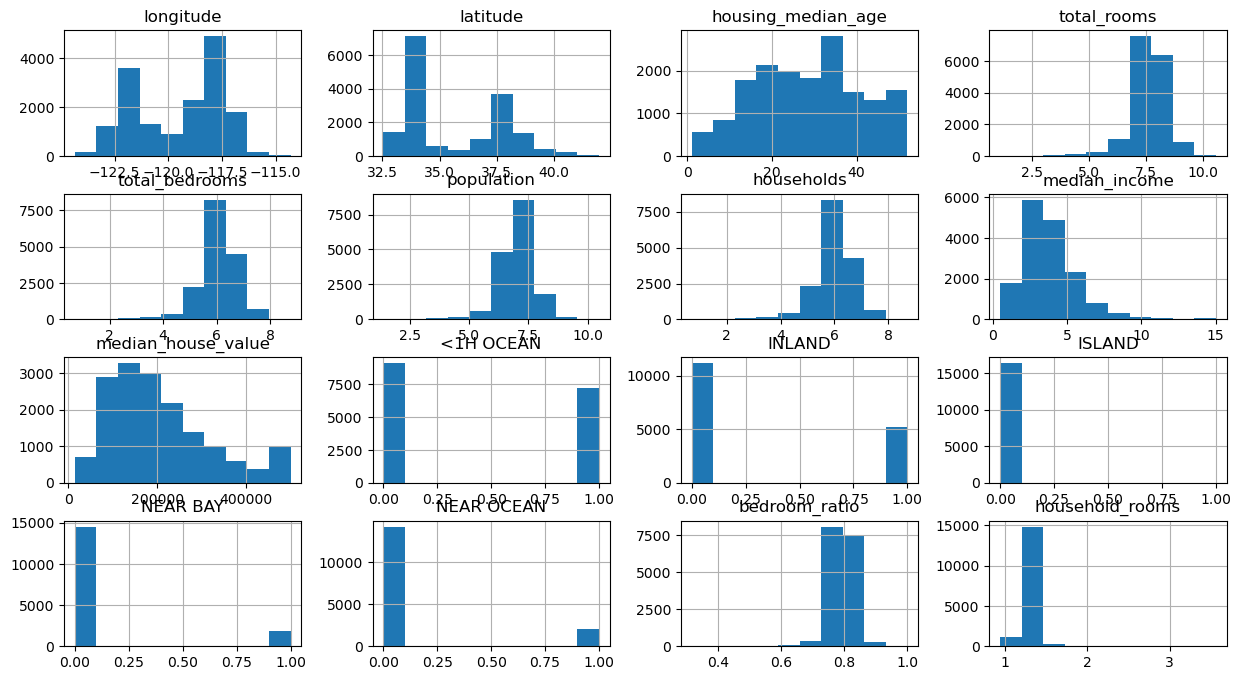

In [9]:
train_data = create_features(X_train, y_train)
train_data.hist(figsize = (15,8))

In [10]:
test_data = create_features(X_test, y_test, columns = 
                            list(train_data.columns.difference(X_train.columns).
                                 difference(['bedroom_ratio', 'household_rooms','median_house_value'])))

<Axes: >

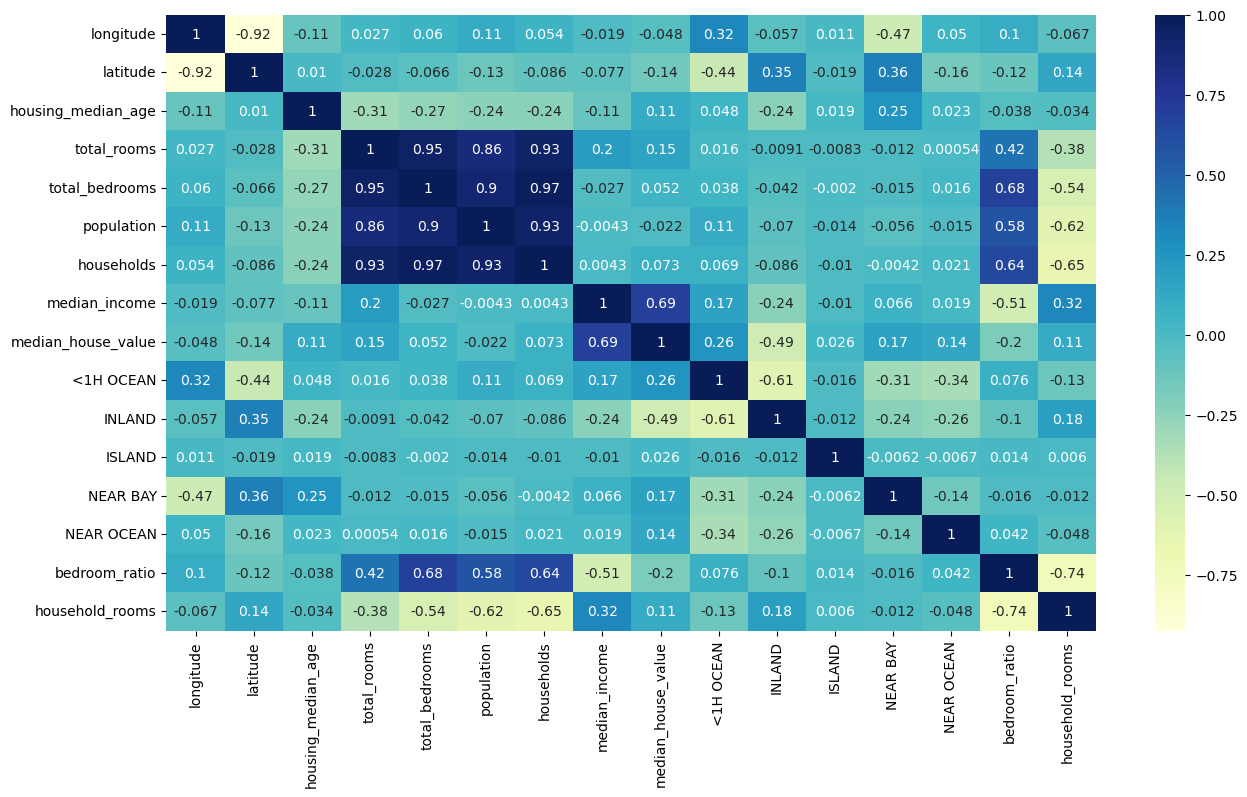

In [11]:
plt.figure(figsize = (15,8))
sns.heatmap(train_data.corr(),annot = True, cmap = 'YlGnBu')

<Axes: xlabel='latitude', ylabel='longitude'>

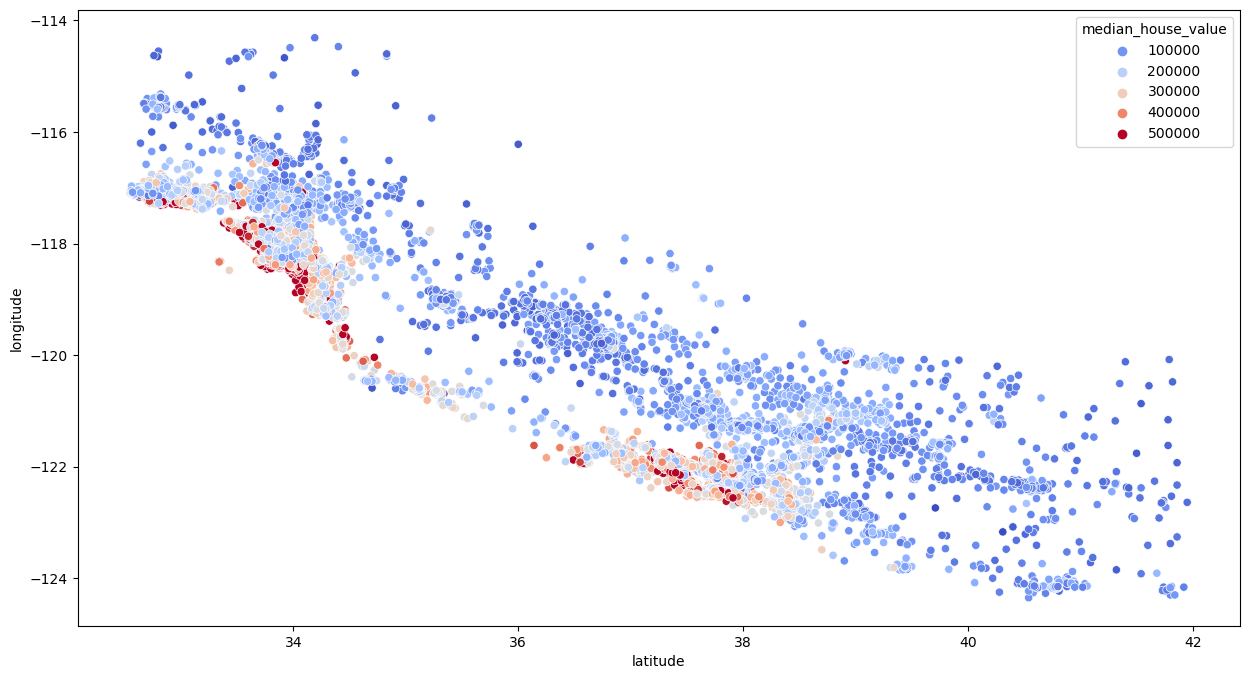

In [12]:
plt.figure(figsize = (15,8))
sns.scatterplot(x = 'latitude',y = 'longitude',data = train_data,hue = 'median_house_value',
                palette = 'coolwarm')

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train, y_train = train_data.drop(['median_house_value'], axis = 1), train_data['median_house_value']
X_train_s = scaler.fit_transform(X_train)
X_test, y_test = test_data.drop(['median_house_value'], axis = 1), test_data['median_house_value']
X_test_s = scaler.fit_transform(X_test)


reg = LinearRegression()
reg.fit(X_train_s, y_train)


LinearRegression()

In [14]:
reg.score(X_test_s,y_test)

0.6710315123124455

In [15]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()

forest.fit(X_train, y_train)

RandomForestRegressor()

In [16]:
forest.score(X_test,y_test)

0.8148986171279176

In [ ]:
from sklearn.model_selection import GridSearchCV

forest = RandomForestRegressor()
param_grid = {
    "n_estimators" : [30, 50, 100],
    "max_features" : [8, 10, 12],
    "max_depth" :[None, 4, 8]
}
grid_search = GridSearchCV(forest, param_grid, cv = 5,
                          scoring = "neg_mean_squared_error",
                          return_train_score = True)

grid_search.fit(X_train, y_train)

In [ ]:
best_forest = grid_search.best_estimator_
best_forest

In [ ]:
best_forest.score(X_test,y_test)

In [17]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Create AdaBoost with a DecisionTreeRegressor as the base estimator
ada_boost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())
ada_boost.fit(X_train, y_train)
ada_boost.score(X_test,y_test)

/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8145047440260704

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Create AdaBoost with a DecisionTreeRegressor as the base estimator
ada_boost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())

# Define a parameter grid to search over
param_grid = {
    "n_estimators": [30, 50, 100],  # Number of boosting stages to be run
    "learning_rate": [0.01, 0.05, 0.1],  # Learning rate shrinks the contribution of each classifier
    "base_estimator__max_depth": [None, 4, 8],  # Maximum depth of the individual regression estimators
}

# Create GridSearchCV object
grid_search = GridSearchCV(ada_boost, param_grid, cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best AdaBoost estimator
best_ada_boost = grid_search.best_estimator_

# Print the best estimator parameters
print(best_ada_boost)

# Evaluate the best model on the test set
score = best_ada_boost.score(X_test, y_test)
print("Test score: ", score)